# Monstrinho 6: A curva de aprendizado
**Objetivo:**  Implemente o registro da curva de aprendizado tanto dos dados de treino quanto de validação no código de redes neurais feito em Python puro nesta disciplina. Além de implementar, treine um modelo de rede neural em um conjunto de dados qualquer e mostre e interprete o gráfico das curvas de aprendizado.

**Comentário:** observe que o enunciado diz claramente que é para realizar a tarefa na rede neural feita em Python puro nos vídeos da disciplina. Se você está usando o ``PyTorch``, ``numpy``, ``tensorflow``, ``keras``, ``lightning`` ou qualquer outra biblioteca pronta, você está no caminho errado!

**Resolução:**

Primeiro, vamos fazer importações relevantes para o processo de definição da rede e obtenção dos dados.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

Agora, vamos definir todas as classes necessárias para o funcionamento da nossa rede neural. Esses códigos não serão mexidos, uma vez que, para implementar a curva de aprendizado, precisamos mudar apenas a parte de treinamento.

In [ ]:
import math

class Value:
    def __init__(self, data, parents=(), parent_operator='', label=''):
        if isinstance(data, Value):
            self.data = data.data
        else:
            self.data = data
        self.parents = parents
        self.parent_operator = parent_operator
        self.label = label
        self.grad = 0
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other_value):
        """self + other_value"""

        if not isinstance(other_value, Value):
            other_value = Value(other_value)
            
        parent_operator = "+"
        parents = (self, other_value)
        data = self.data + other_value.data

        result = Value(data, parents, parent_operator)

        def propagate_add():
            self.grad += result.grad * 1 # grad filho * derivada filho em relação a mãe
            other_value.grad += result.grad * 1
        
        result.propagate = propagate_add # sobrescreve a função de propagar do vértice filho

        return result
    
    def __radd__(self, other_value):
        """other_value + self"""

        return self + other_value
    
    def __sub__(self, other_value):
        """self - other_value"""
        return self + (- other_value)
    
    def __rsub__(self, other_value):
        return other_value + (-self)

    def __mul__(self, other_value):
        """self * other_val"""
        
        if not isinstance(other_value, Value):
            other_value = Value(other_value)

        parent_operator = "*"
        parents = (self, other_value)
        data = self.data * other_value.data

        result = Value(data, parents, parent_operator)

        def propagate_mul():
            self.grad += result.grad * other_value.data # grad filho * derivada filho em rel. mae
            other_value.grad += result.grad * self.data
        
        result.propagate = propagate_mul
        
        return result
    
    def __rmul__(self, other_value):
        """other_val * self"""
        return self * other_value
    
    def __pow__(self, exponential):
        """self ** expoente"""

        # certificando-se que o expoente é um inteiro ou float
        assert isinstance(exponential, (int, float))

        parent_operator = f"**{exponential}"
        parents = (self, )
        data = self.data ** exponential

        result = Value(data, parents, parent_operator)

        def propagate_pow():
            self.grad += result.grad * (exponential * self.data ** (exponential - 1))

        result.propagate = propagate_pow
    
        return result
    
    def __truediv__(self, other_value):
        """self / other_value"""

        return self * (other_value ** (-1))
    
    def __rtruediv__(self, other_value):
        return self / other_value

    def __neg__(self):
        """ - self """
        return self * (-1)
    
    def exp(self, d = None):
        """exp(self)"""

        if d == None:
            d = self

        if not isinstance(d, Value):
            d = Value(d)

        parent_operator = "exp"
        parent = (self, )
        try:
            data = math.exp(d.data)
        except OverflowError:
            print("Erro de Overflow!")
            data = float("inf")
            
        result = Value(data, parent, parent_operator)

        def propagate_exp():
            self.grad += result.grad * data # gradiente filho * derivada filho em rel. mae
        
        result.propagate = propagate_exp

        return result
    
    def sig(self):
        """exp(self) / (exp(self) + 1)"""

        return self.exp() / (self.exp() + 1)
    
    def relu(self):
        """max(0, self)"""

        parent_operator = "relu"
        parent = (self, )
        data = max(0, self.data)
        result = Value(data, parent, parent_operator)

        def propagate_relu():
            self.grad += (1.0 if self.data > 0 else 0.0) * result.grad
        
        result.propagate = propagate_relu
        return result
    
    def log(self, d, base=math.e):
        """log(self)"""

        if not isinstance(d, Value):
            d = Value(d)

        # certificando-se que a base é um inteiro ou float positivo
        assert isinstance(base, (int, float))
        assert base > 0

        parent_operator = f"log{base}"
        parents = (self, )
        data = math.log(d.data, base)

        result = Value(data, parents, parent_operator)

        def propagate_log():
            if data == 0:
                self.grad = 0
            else:
                self.grad += result.grad * ((data * math.log(base)) ** (-1)) # gradiente filho * derivada filho em rel. mae
        
        result.propagate = propagate_log

        return result

    def softplus(self):
        """ln(1 + exp(self))"""
        
        return self.log((1 + self.exp()))
    
    def swish(self, beta=1):
        """self * (1 + exp(-beta * self))^-1"""

        assert isinstance(beta, (int, float))

        return self * (1 + (1 / self.exp(((-beta) * self.data)))) 

    def propagate(self):
        pass

    def propagate_all(self):
        """Propagação que só pode ser feita a partir do vértice folha."""
        self.grad = 1
        
        # Busca em profundidade
        topological_order = []
        visited = set()
        def build_top_order(v):
            if v not in visited:
                visited.add(v)
                for parent in v.parents:
                    build_top_order(parent)
                topological_order.append(v)
        
        build_top_order(self)
        
        for v in reversed(topological_order):
            v.propagate()

class Neuronio:
    def __init__(self, num_dados_entrada):
        self.vies = Value(random.uniform(-1,1))

        self.pesos = []
        for _ in range(num_dados_entrada):
            self.pesos.append(Value(random.uniform(-1,1)))
    
    def __call__(self, x, tipo_ativacao='sig'):
        # calcula o dado de saída

        assert len(x) == len(self.pesos) # evita erros posteriores

        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno

        soma += self.vies

        if tipo_ativacao == 'sig':
            dado_de_saida = soma.sig()
        elif tipo_ativacao == 'relu':
            dado_de_saida = soma.relu()
        elif tipo_ativacao == 'softplus':
            dado_de_saida = soma.softplus()
        elif tipo_ativacao == 'swish':
            dado_de_saida = soma.swish()
        else:
            dado_de_saida = soma

        return dado_de_saida
    
    def parametros(self):
        return self.pesos + [self.vies]

class Camada:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []

        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)

        self.neuronios = neuronios

    def __call__(self, x, tipo_ativacao='sig'):
        dados_de_saida = []

        for neuronio in self.neuronios:
            informacao = neuronio(x, tipo_ativacao)
            dados_de_saida.append(informacao)
        
        if len(dados_de_saida) == 1:
            return dados_de_saida[0] # garante que o valor retornado seja um número caso estejamos na output layer
        else:
            return dados_de_saida # para hidden layers
    
    def parametros(self):
        params = []

        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio) # concatena listas

        return params

class MLP:
    def __init__(self, num_dados_entrada: int, num_neuronios_por_camada: list):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        camadas = []

        # estamos criando apenas a partir da primeira camada escondida
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
        
        self.camadas = camadas
    
    def __call__(self, x, tipo_ativacao='sig'):
        
        for camada in self.camadas:
            x = camada(x, tipo_ativacao) # transforma x a cada camada chamada

        return x # retorna apenas um valor, representando apenas o output
    
    def parametros(self):
        params = []

        for camada in self.camadas:
            params_camada = camada.parametros()
            params.extend(params_camada) # concatena listas

        return params

Nessa etapa, faremos a importação e o tratamento do *dataset* utilizado para treinar nossa rede neural. Utilizaremos dados obtidos no *dataset* `iris`, do módulo `seaborn`:

In [3]:
# importação do dataset e definição dos atributos e target
ATRIBUTOS = ["sepal_length", "sepal_width", "petal_length"]
TARGET = ["petal_width"]

df = sns.load_dataset("iris")

df = df.reindex(ATRIBUTOS + TARGET, axis=1)
df = df.dropna()

# separação entre treino e teste
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 210924

indices = df.index
indices_treino_val, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino_val = df.loc[indices_treino_val]
df_teste = df.loc[indices_teste]

X_teste = df_teste.reindex(ATRIBUTOS, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values

# separação entre treino e validação
TAMANHO_VALIDACAO = 0.1

indices = df_treino_val.index
indices_treino, indices_val = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df.loc[indices_treino]
df_val = df.loc[indices_val]

X_treino = df_treino.reindex(ATRIBUTOS, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values

X_val = df_val.reindex(ATRIBUTOS, axis=1).values
y_val = df_val.reindex(TARGET, axis=1).values

# normalizamos os dados pelo máximo absoluto
x_scaler = MaxAbsScaler()
x_scaler.fit(X_treino)

y_scaler = MaxAbsScaler()
y_scaler.fit(y_treino)

X_treino = x_scaler.transform(X_treino)
y_treino = y_scaler.transform(y_treino).reshape(-1)

X_val = x_scaler.transform(X_val)
y_val = y_scaler.transform(y_val).reshape(-1)

X_teste = x_scaler.transform(X_teste)
y_teste = y_scaler.transform(y_teste).reshape(-1)

Finalmente, podemos definir e treinar nossa rede neural. Para esse teste, utilizaremos a função de ativação sigmoidal e definiremos a quantidade de épocas de treinamento como 20. A mudança maior desse código para o anteriormente visto na disciplina é a criação de duas listas: uma relacionada a perdas dos dados de treino, outra relacionada às perdas ocorridas na validação. Essas listas servirão para plotar a curva de aprendizado posteriormente.

In [4]:
# definição da arquitetura inicial da rede
NUM_DADOS_ENTRADA = 3
NUM_DADOS_SAIDA = 1
CAMADAS_OCULTAS = [3,2]

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_SAIDA]

minha_mlp = MLP(NUM_DADOS_ENTRADA, arquitetura_da_rede)

# treinamento da rede
NUM_EPOCAS = 20
TAXA_DE_APRENDIZADO = 0.01

perda_treino = []
perda_validacao = []

for epoca in range(NUM_EPOCAS):

    # forward_pass
    y_pred_treino = []
    for exemplo in X_treino:
        previsao = minha_mlp(exemplo)
        y_pred_treino.append(previsao)
    
    y_pred_val = []
    for x in X_val:
        prev = minha_mlp(x)
        y_pred_val.append(prev)
    
    # loss
    erros = []
    for yt, yp in zip(y_treino, y_pred_treino):
        residuo = yt - yp
        erro_quadratico = residuo ** 2
        erros.append(erro_quadratico)
    
    loss_treino = sum(erros)
    perda_treino.append(loss_treino.data)

    erros_val = []
    for yt, yv in zip(y_val, y_pred_val):
        residuo = yt - yv
        erro_quadratico = residuo ** 2
        erros_val.append(erro_quadratico)

    loss_val = sum(erros_val)
    perda_validacao.append(loss_val.data)

    # zero grad
    for p in minha_mlp.parametros():
        p.grad = 0
    
    # backpropagation
    loss_treino.propagate_all()

    # atualiza parametros
    for p in minha_mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

Finalmente, é possível fazer a curva de aprendizado dessa MLP a partir dos dados anteriores.

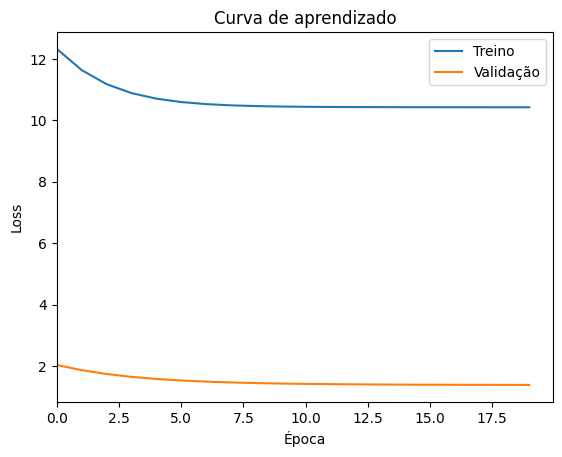

In [5]:
sns.lineplot(perda_treino, label="Treino")
eixo = sns.lineplot(perda_validacao, label="Validação")

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss");

É perceptível que há um platô, e não é possível afirmar se haveria grande mudança com mais épocas. Não se verifica um aumento expressivo da perda com o passar das épocas, o que indica que não há sobreajuste. Vamos verificar o RMSE do modelo:

In [6]:
y_pred = []
for exemplo in X_teste:
    previsao = minha_mlp(exemplo)
    y_pred.append(previsao.data)

RMSE = root_mean_squared_error(y_pred, y_teste)
print(RMSE)

0.3737779268958422
